#**Phase 1 Milestone Assignment**

##**Identity**

Ihsan Aulia Rahman

Full Time Data Science

HCK-Batch-001

#**A. Description**

##**A.1. Problem Statement**

Banana is the most traded fruit in the world right now. This fruit is the bread and butter of many South American countries and in high demand around the world. Due to this, it is a common practice to let bananas ripe during transport to other side of the world. However, some bananas could become overripe or even stale on their way to the destination. A single container can contain 48,000 bananas making inspection job a labour intensive task. Therefore, an automatic system is very desirable for transport companies.

##**A.2. Objective**

This project's goal is to build a classifier system that can differentiate fresh and stale bananas through photographs using convolutional neural network.

#**B. Libraries**

Here we import all functions necessary for our project.

##**B.1. Exploratory Functions**

In [1]:
import numpy as np              # Math calculations
import pandas as pd             # Tabular data handling
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns           # Data visualization
import cv2                      # Read image data 
import scipy                    # Statistic calculations
import scipy.stats as stats     # Statistic calculations
import time                     # Track process duration
import os                       # Set directories for data
import glob                     # Set directories for data
import warnings                 # Ignore warnings
from google.colab import files  # Upload files

warnings.simplefilter('ignore')

##**B.2. Modelling Functions**

In [53]:
# Split and Preprocess Datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Neural Network Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

# Evaluate Classification Models
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Save Model Files
import joblib 
import json 
import pickle

#**C. Loading and EDA**

##**C.1. Data Loading**

We are loading a dataset from Kaggle using API. We need to install the API file first.

In [3]:
! pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iarahman","key":"70e3bc0074553edd087b5594b2934763"}'}

Create root directory.

In [4]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle  
!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

In [5]:
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle 

kaggle.json


Download the data from Kaggle

In [6]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables
!unzip -q /content/fresh-and-stale-images-of-fruits-and-vegetables.zip -d images

 99% 1.40G/1.41G [00:15<00:00, 100MB/s]
100% 1.41G/1.41G [00:15<00:00, 97.0MB/s]


Obtain the required data for training and testing our neural network models.

In [7]:
main_path = '/content/images'
fresh_dir = os.path.join(main_path, 'fresh_banana')
stale_dir = os.path.join(main_path, 'stale_banana')

In [8]:
fresh_banana = glob.glob(fresh_dir+"/*.png")
stale_banana = glob.glob(stale_dir+"/*.png")

In [9]:
def image_list_to_dataframe(images_list):
    data = []
    for image in images_list:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

fresh_banana_df = image_list_to_dataframe(fresh_banana)
fresh_banana_df = fresh_banana_df.sample(frac=1, random_state=11).reset_index(drop=True)

stale_banana_df = image_list_to_dataframe(stale_banana)
stale_banana_df = stale_banana_df.sample(frac=1, random_state=11).reset_index(drop=True)

In [10]:
print(f'fresh bananas: {len(fresh_banana_df)} images')
print(f'stale bananas: {len(stale_banana_df)} images')

fresh bananas: 1581 images
stale bananas: 1467 images


Split the data into training, validation and testing batches.

In [11]:
train_val_fresh_df, test_fresh_df = train_test_split(fresh_banana_df, test_size=0.2, random_state=111)
train_fresh_df, val_fresh_df = train_test_split(train_val_fresh_df, test_size=0.2, random_state=111)

train_val_stale_df, test_stale_df = train_test_split(stale_banana_df, test_size=0.2, random_state=111)
train_stale_df, val_stale_df = train_test_split(train_val_stale_df, test_size=0.2, random_state=111)

train_df = pd.concat([train_fresh_df, train_stale_df])
val_df = pd.concat([val_fresh_df, val_stale_df])
test_df = pd.concat([test_fresh_df, test_stale_df])

##**C.2. Exploratory Data Analysis**

In [12]:
num_train_fresh = len(train_df[train_df.label == "fresh_banana"])
num_train_stale = len(train_df[train_df.label == "stale_banana"])
num_val_fresh = len(val_df[val_df.label == "fresh_banana"])
num_val_stale = len(val_df[val_df.label == "stale_banana"])
num_test_fresh = len(test_df[test_df.label == "fresh_banana"])
num_test_stale = len(test_df[test_df.label == "stale_banana"])

print(f'train images - fresh: {num_train_fresh}')
print(f'train images - stale: {num_train_stale}')
print(f'train images - total: {len(train_df)}')
print('='*30)
print(f'val images - fresh  : {num_val_fresh}')
print(f'val images - stale  : {num_val_stale}')
print(f'val images - total  : {len(val_df)}')
print('='*30)
print(f'test images - fresh : {num_test_fresh}')
print(f'test images - stale : {num_test_stale}')
print(f'test images - total : {len(test_df)}')

train images - fresh: 1011
train images - stale: 938
train images - total: 1949
val images - fresh  : 253
val images - stale  : 235
val images - total  : 488
test images - fresh : 317
test images - stale : 294
test images - total : 611


We have around 3000 images divided 4:1:1 for training, validation and testing.

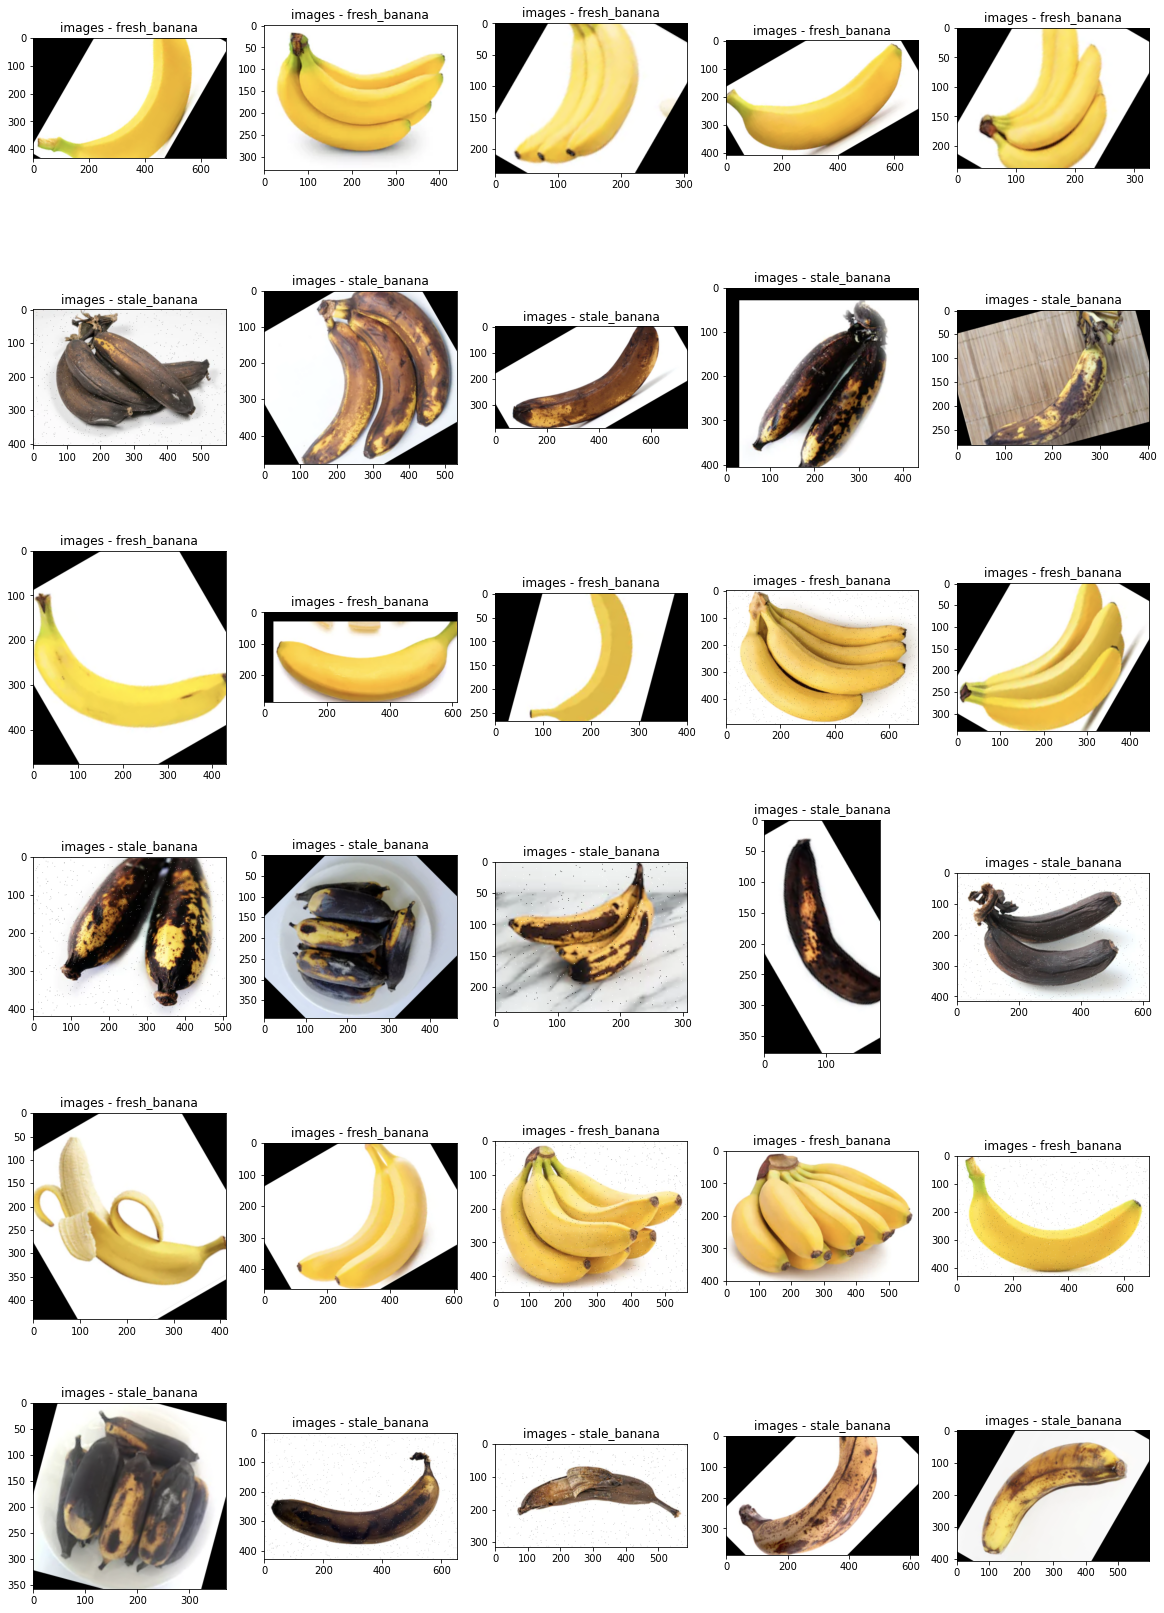

In [ ]:
train_head = (train_df['images'].iloc[:5]).tolist()
train_tail = (train_df['images'].iloc[-5:]).tolist()
val_head = (val_df['images'].iloc[:5]).tolist()
val_tail = (val_df['images'].iloc[-5:]).tolist()
test_head = (test_df['images'].iloc[:5]).tolist()
test_tail = (test_df['images'].iloc[-5:]).tolist()

def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(20,30))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-3] + ' - ' + sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(train_head + train_tail + val_head + val_tail + test_head + test_tail)

The images are fresh and stale bananas as expected. Most of them on blank white background while some on ordinary background such as plates and tabletops.Most of the images are already augmented with rotation, shifting and zooming.

#**D. Preprocessing**

We are going to preprocess the images to better suit the prediction models.

In [13]:
# Set some variables for quick call 
HEIGHT = 200
WIDTH = 200
SEED = 111
BATCH = 64

In [14]:
# Augment training dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

ds_train = train_datagen.flow_from_dataframe(dataframe=train_df,
                                             x_col='images',
                                             y_col='label',
                                             target_size=(HEIGHT, WIDTH),
                                             class_mode='binary',
                                             batch_size=BATCH,
                                             shuffle=True,
                                             seed=SEED)

Found 1949 validated image filenames belonging to 2 classes.


In [15]:
# Augment validation dataset
vaL_datagen = ImageDataGenerator(rescale=1./255)

ds_val = vaL_datagen.flow_from_dataframe(dataframe=val_df,
                                         x_col='images',
                                         y_col='label',
                                         target_size=(HEIGHT, WIDTH),
                                         class_mode='binary',
                                         batch_size=BATCH,
                                         shuffle=False,
                                         seed=SEED)

Found 488 validated image filenames belonging to 2 classes.


In [16]:
# Augment testing dataset
test_datagen = ImageDataGenerator(rescale=1./255)

ds_test = test_datagen.flow_from_dataframe(dataframe=test_df,
                                           x_col='images',
                                           y_col='label',
                                           target_size=(HEIGHT, WIDTH),
                                           class_mode='binary',
                                           batch_size=BATCH,
                                           shuffle=False,
                                           seed=SEED)

Found 611 validated image filenames belonging to 2 classes.


#**E. Modelling**

Now we build the models for our project. 

##**E.1. Definition**

The initial model would be a straightforward sequential model with 3 pairs of convolutional-pooling layers to extract features from the images, and then topped with 3 layers of deep neural network.

In [17]:
inputs= [HEIGHT, WIDTH, 3]

model_1= Sequential()

model_1.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Flatten())
model_1.add(Dense(units= 128, activation='relu'))
model_1.add(Dense(units= 64, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

##**E.2. Training**

We compile the model using `adam` optimizer and `binary_crossentropy` loss function.

In [19]:
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
history= model_1.fit(ds_train, batch_size = BATCH, epochs = 20, validation_data = ds_val)

Epoch 1/20
31/31 [==============================] - 99s 3s/step - loss: 0.6585 - accuracy: 0.6562 - val_loss: 0.3006 - val_accuracy: 0.8873
Epoch 2/20
31/31 [==============================] - 97s 3s/step - loss: 0.1849 - accuracy: 0.9312 - val_loss: 0.0552 - val_accuracy: 0.9795
Epoch 3/20
31/31 [==============================] - 99s 3s/step - loss: 0.1643 - accuracy: 0.9348 - val_loss: 0.0571 - val_accuracy: 0.9795
Epoch 4/20
31/31 [==============================] - 96s 3s/step - loss: 0.0671 - accuracy: 0.9785 - val_loss: 0.0323 - val_accuracy: 0.9918
Epoch 5/20
31/31 [==============================] - 95s 3s/step - loss: 0.0777 - accuracy: 0.9774 - val_loss: 0.0400 - val_accuracy: 0.9877
Epoch 6/20
31/31 [==============================] - 95s 3s/step - loss: 0.0516 - accuracy: 0.9795 - val_loss: 0.0942 - val_accuracy: 0.9816
Epoch 7/20
31/31 [==============================] - 97s 3s/step - loss: 0.0432 - accuracy: 0.9856 - val_loss: 0.0584 - val_accuracy: 0.9898
Epoch 8/20
31/31 [==

##**E.3. Evaluation**

Our model get 90% validation accuracy straight off the bat. is this legit, or a serious overfitting?

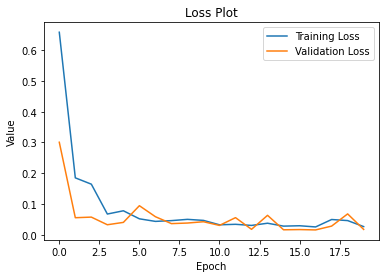

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

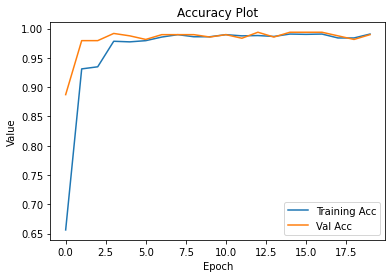

In [22]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [23]:
test_results = model_1.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0054
Test Accuracy : 0.9984


Turns out it isn't. We shall check if there was a data leakage by initializing a new model.

##**E.4. Improvement**

In [24]:
inputs= [HEIGHT, WIDTH, 3]

model_2= Sequential()

model_2.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
model_2.add(MaxPooling2D(pool_size=2, strides=2))
model_2.add(tf.keras.layers.Dropout(rate=0.1)) # Added dropout layer

model_2.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))
model_2.add(tf.keras.layers.Dropout(rate=0.1)) # Added dropout layer

model_2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))# Added batch normalization
model_2.add(tf.keras.layers.Dropout(rate=0.1)) # Added dropout layer

model_2.add(Flatten())

model_2.add(Dense(units= 128, activation='relu'))
model_2.add(tf.keras.layers.BatchNormalization()) # Added batch normalization
model_2.add(tf.keras.layers.Dropout(rate=0.1)) # Added dropout layer

model_2.add(Dense(units= 64, activation='relu'))
model_2.add(tf.keras.layers.BatchNormalization()) # Added batch normalization
model_2.add(tf.keras.layers.Dropout(rate=0.1)) # Added dropout layer

model_2.add(Dense(units=1, activation='sigmoid'))

In [25]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 99, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 32)       

In [26]:
OPT = keras.optimizers.Adam(clipvalue = 1.0) # Added clipvalue
model_2.compile(optimizer = OPT, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
history_2= model_2.fit(ds_train, batch_size = BATCH, epochs = 20, validation_data = ds_val)

Epoch 1/20
31/31 [==============================] - 106s 3s/step - loss: 0.2503 - accuracy: 0.8984 - val_loss: 4.1530 - val_accuracy: 0.5184
Epoch 2/20
31/31 [==============================] - 101s 3s/step - loss: 0.1228 - accuracy: 0.9559 - val_loss: 0.2863 - val_accuracy: 0.8730
Epoch 3/20
31/31 [==============================] - 102s 3s/step - loss: 0.1062 - accuracy: 0.9620 - val_loss: 1.0704 - val_accuracy: 0.5348
Epoch 4/20
31/31 [==============================] - 102s 3s/step - loss: 0.0599 - accuracy: 0.9826 - val_loss: 0.4632 - val_accuracy: 0.7520
Epoch 5/20
31/31 [==============================] - 105s 3s/step - loss: 0.0546 - accuracy: 0.9831 - val_loss: 0.0535 - val_accuracy: 0.9918
Epoch 6/20
31/31 [==============================] - 101s 3s/step - loss: 0.0543 - accuracy: 0.9841 - val_loss: 0.1119 - val_accuracy: 0.9775
Epoch 7/20
31/31 [==============================] - 100s 3s/step - loss: 0.0462 - accuracy: 0.9861 - val_loss: 0.0360 - val_accuracy: 0.9877
Epoch 8/20
31

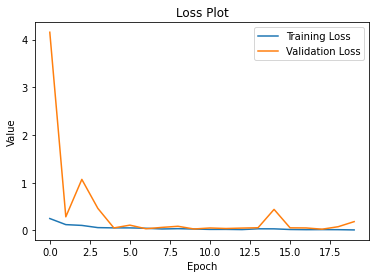

In [28]:
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

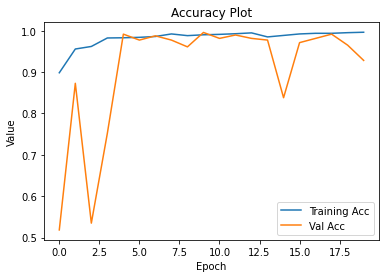

In [29]:
plt.plot(history_2.history['accuracy'], label='Training Acc')
plt.plot(history_2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [30]:
test_results = model_2.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2009
Test Accuracy : 0.9313


Well that made it slightly worse. We will stick with the original model.

##**E.5. Deployment**

After we build the final pipeline, we can download it in h5 format using this prompt.

In [56]:
model_1.save('fresh_stale_banana.h5')

The pickle file is then bundled with support files in a web app folder.

#**F. Inferencing**

With the finished model, we can try it out ourself with an image upload.

In [38]:
def inference(uploaded):
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(HEIGHT, WIDTH))
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model_1.predict(images)
    score = tf.nn.sigmoid(classes[0])
    class_name = ds_train.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}
    
    if classes[0]>0.5:
      print(f" This image most likely belongs to '{class_name_inverted[1]}'.")
    else:
      print(f" This image most likely belongs to '{class_name_inverted[0]}'.")

Saving _85500701_bunch-of-seven-think-976.jpg to _85500701_bunch-of-seven-think-976.jpg
Saving 144807745-spoiled-darkened-bananas-on-a-white-background-old-stale-fruits-on-a-light-table-perishable-natural-.png to 144807745-spoiled-darkened-bananas-on-a-white-background-old-stale-fruits-on-a-light-table-perishable-natural-.png
Saving Bananas-218094b-scaled.jpg to Bananas-218094b-scaled.jpg
Saving brett-jordan-zrF6ACPLhPM-unsplash.jpg to brett-jordan-zrF6ACPLhPM-unsplash.jpg
Saving bunch-of-bananas.jpg to bunch-of-bananas.jpg
Saving fresh.jpg to fresh.jpg
Saving overripe-bananas-nutrition.jpg to overripe-bananas-nutrition.jpg
Saving stale.jpeg to stale.jpeg
Saving stale-banana-17615337.jpg to stale-banana-17615337.jpg
Saving what-to-do-with-overripe-bananas-info.jpg to what-to-do-with-overripe-bananas-info.jpg


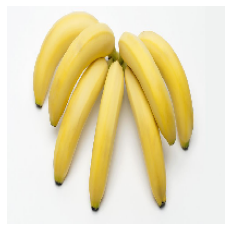

1/1 [==============================] - 0s 32ms/step
 This image most likely belongs to 'fresh_banana'.


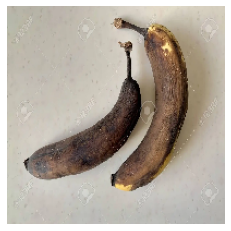

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'stale_banana'.


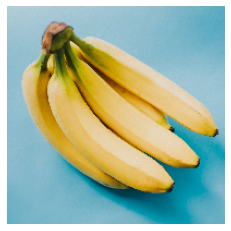

1/1 [==============================] - 0s 31ms/step
 This image most likely belongs to 'fresh_banana'.


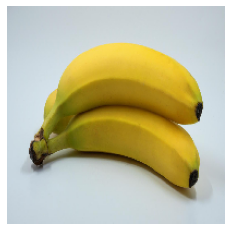

1/1 [==============================] - 0s 41ms/step
 This image most likely belongs to 'fresh_banana'.


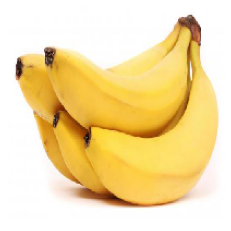

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'fresh_banana'.


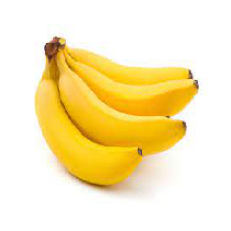

1/1 [==============================] - 0s 29ms/step
 This image most likely belongs to 'fresh_banana'.


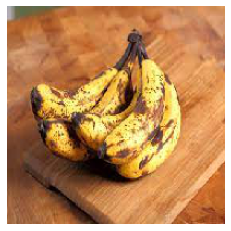

1/1 [==============================] - 0s 29ms/step
 This image most likely belongs to 'stale_banana'.


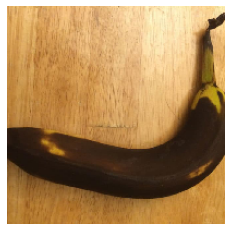

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'stale_banana'.


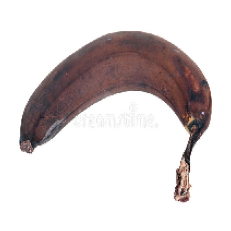

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'stale_banana'.


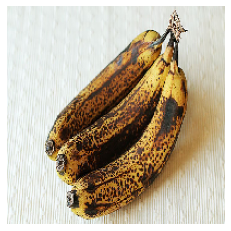

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'stale_banana'.


In [49]:
uploaded = files.upload()

inference(uploaded)

It seems our model can differentiate real images of bananas very well. Let's try with illustrations of bananas and things that are not bananas

Saving banana-vector-bananas-vector-illustration_75817-914.png to banana-vector-bananas-vector-illustration_75817-914.png
Saving fresh cartoon.png to fresh cartoon.png
Saving spoiled-rotten-banana-fruit-skin-covered-stinky-rot-vector-illustration-spoiled-rotten-banana-fruit-skin-172335395.jpg to spoiled-rotten-banana-fruit-skin-covered-stinky-rot-vector-illustration-spoiled-rotten-banana-fruit-skin-172335395.jpg
Saving stale cartoon.jpg to stale cartoon.jpg


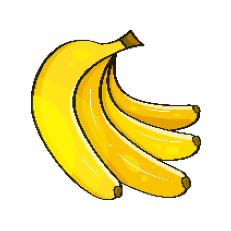

1/1 [==============================] - 0s 33ms/step
 This image most likely belongs to 'fresh_banana'.


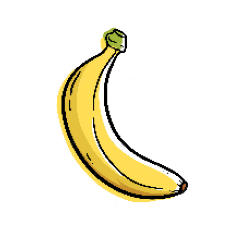

1/1 [==============================] - 0s 40ms/step
 This image most likely belongs to 'fresh_banana'.


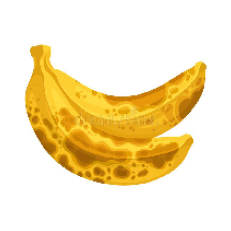

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'fresh_banana'.


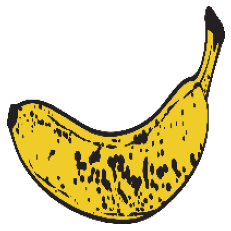

1/1 [==============================] - 0s 31ms/step
 This image most likely belongs to 'fresh_banana'.


In [51]:
uploaded_1 = files.upload()

inference(uploaded_1)

Saving bfed8230d231fd7edb55132378d961c4.jpg to bfed8230d231fd7edb55132378d961c4.jpg
Saving whn-yellow-1_2021-09-22T09-28-42.jpg to whn-yellow-1_2021-09-22T09-28-42.jpg
Saving Minion_phil.jpg to Minion_phil.jpg
Saving 478px-Joko_Widodo_2014_official_portrait.jpg to 478px-Joko_Widodo_2014_official_portrait.jpg


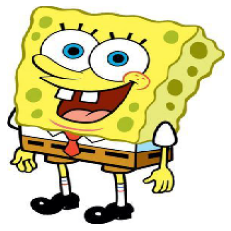

1/1 [==============================] - 0s 31ms/step
 This image most likely belongs to 'fresh_banana'.


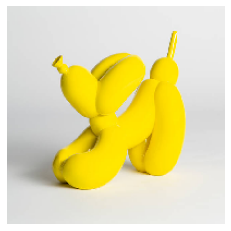

1/1 [==============================] - 0s 30ms/step
 This image most likely belongs to 'fresh_banana'.


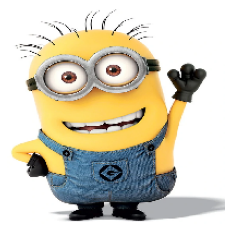

1/1 [==============================] - 0s 35ms/step
 This image most likely belongs to 'fresh_banana'.


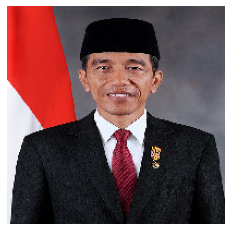

1/1 [==============================] - 0s 31ms/step
 This image most likely belongs to 'stale_banana'.


In [50]:
uploaded_2 = files.upload()

inference(uploaded_2)

It seems our model is tad overfit to images of real bananas. It classify all cartoon bananas or anything yellow as `fresh_banana`.

#**G. Conclusion**

For a human, differentiating between fresh and stale bananas is of a simplest task. A fresh (Cavendish) banana has smooth and bright yellow skin. A little smudge of brown or even black gave signal in our brain that a banana is unpalatable and classified as stale.

Using these labelling done by humans, we trained a machine to understand just that. We don't exactly know what the machine deduced in order to differentiate fresh and stale bananas but it did the job pretty well.

Though our model has 99% prediction accuracy, it is limited to real images only. Nevertheless, based on our project background and objective, we have successfully built a convolutional neural network to differentiate fresh and stale bananas.

References:

https://www.kaggle.com/code/leekahwin/child-or-adult-deep-convo-neural-net#12.0-|-Test-Your-Own-Images--

https://colab.research.google.com/drive/1KwBHCQmQZHVUWiaeNtSbFIxmLksaoHUH?usp=sharing#scrollTo=MRfjfIXPaaHr

https://www.tensorflow.org/tutorials/images/transfer_learning#configure_the_dataset_for_performance